In [1]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from functools import reduce
import sympy as sm
import scipy as sc
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit
from math import floor
from itertools import product

θ = sm.symbols('theta')
α = sm.symbols('alpha', integer=True, positive=True)
Y = sm.symbols('Y')
sm.init_printing()

In [61]:
# https://math.stackexchange.com/questions/3291489/can-the-fibonacci-lattice-be-extended-to-dimensions-higher-than-3

SyntaxError: invalid syntax (<ipython-input-61-e89f8a7b3465>, line 1)

In [2]:
rho_func = (1/sm.sqrt(sm.pi))*(sm.gamma((α + 1) / 2) / sm.gamma(α / 2))*sm.Pow(sm.sin(θ), α-1)
Y_func = sm.integrate(rho_func, (θ, 0, θ))

In [110]:
Y_sols = []
for i in range(1, 9):
    Y_sols.append(sm.simplify(sm.trigsimp(sm.simplify(Y_func.subs({α: i})), method='fu')))
Y_sols[0] = Y_sols[0]/2 # manually remap output to [0, 2*pi]

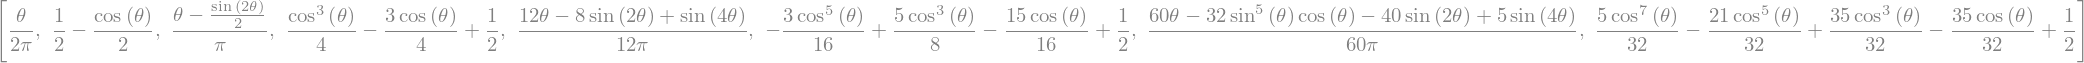

In [162]:
Y_sols

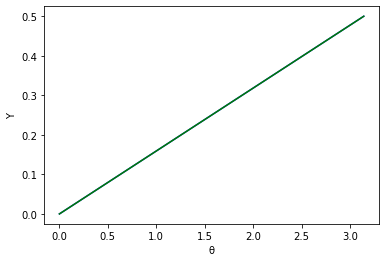

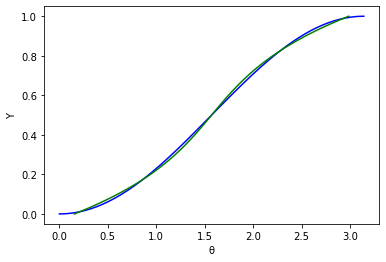

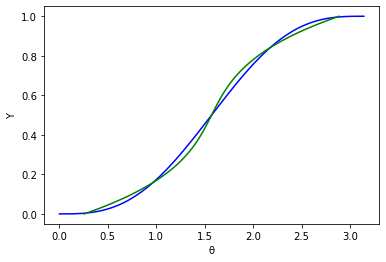

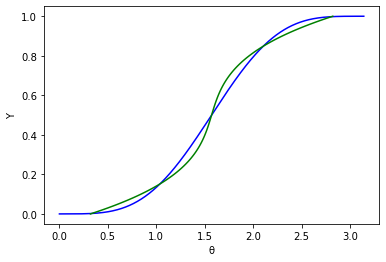

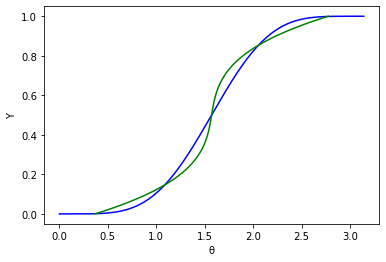

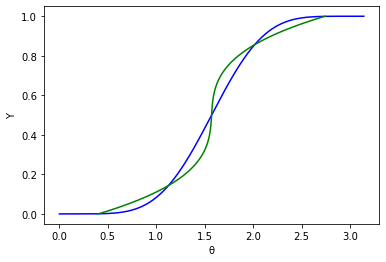

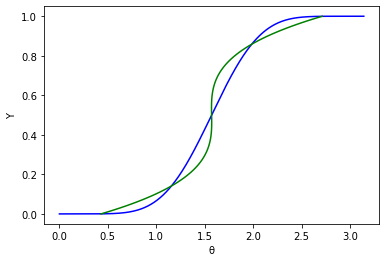

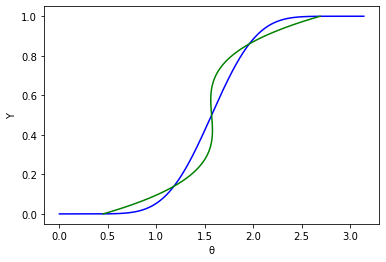

In [163]:
# plot
theta_grid = np.linspace(0, np.pi, 1000)
y_grid = np.linspace(-.2, 1.2, 1000)
offsets = np.linspace(-.1, .1, 1000)
# pretty bad, but good enough for now--let's get some noise
fits = []

for sol in Y_sols:
    Y_grid = sm.lambdify(θ, sol, 'numpy')(theta_grid)

    fit = np.polynomial.polynomial.Polynomial.fit(Y_grid, theta_grid, deg=3)
    fits.append(fit)
    xx, yy = fit.linspace()
    
    plt.plot(theta_grid, Y_grid, color='b')
    plt.plot(yy, xx, color='g')
    
    plt.ylabel('Y')
    plt.xlabel('θ')
    plt.show()

In [112]:
def fibonacci_grid(num_pts, e=3.5):
    phi = (1 + np.sqrt(5)) / 2
    pts = [(0, 0),]
    for i in range(1, num_pts-1):
        pts.append(((i + e) / (num_pts - 1 + 2*e), i / phi))
    
    pts.append((1, 0))
    return np.array(pts)

def fibonacci_cube(num_planes, e=3.5):
    phi = (1 + np.sqrt(5)) / 2
    plane = fibonacci_grid(num_planes, e=3.5)
    cube = []
    for i in range(num_planes):
        cube.append(np.concatenate((plane, np.full((plane.shape[0], 1), (i / phi) % 1)), 1))
        
    return np.concatenate(cube)    

def spiral_xform(pts):
    xformed = []
    for i, pt in enumerate(pts):
        r, theta = np.sqrt(pt[0]), 2*np.pi*(pt[1])
        xformed.append((r*np.cos(theta), r*np.sin(theta)))
    return np.array(xformed)

def spherical_xform(pts):
    xformed = []
    for i, pt in enumerate(pts):
        theta, phi = np.pi*2*pt[1], np.arccos(1-2*pt[0])
        xformed.append((np.sin(theta)*np.sin(phi), np.cos(theta)*np.sin(phi), np.cos(phi)))
    return np.array(xformed)
        
def hyperspherical_xform(pts):
    xformed = []
    for i, pt in enumerate(pts):
        # 1-2*x: mapping values 0-1 -> -1-1
        theta, phi, chi = np.pi*2*pt[0], np.arccos(1-2*pt[1]), np.arccos(1-2*pt[2])
        xformed.append((np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)*np.cos(chi), np.cos(theta), np.sin(theta)*np.sin(phi)*np.sin(chi)))
    return np.array(xformed)


def nspherical_to_cartesian(r, *angles):
    from math import sin, cos
    from functools import reduce
    ndim = len(angles) + 1
    pt = np.zeros(ndim)
    for i in range(ndim):
        pt[i] = reduce(lambda a, b: a*b, (sin(angles[k]) for k in range(i)), 1) * (cos(angles[i]) if i < ndim-1 else 1)
    
    return pt

In [216]:
def quintic(t: float):
    return t * t * t * (t * (t * 6 - 15) + 10)

def lerp(t, a, b):
    return a + t * (b - a)

ptable = [151,160,137,91,90,15,
          131,13,201,95,96,53,194,233,7,225,140,36,103,30,69,142,8,99,37,240,21,10,23,
          190, 6,148,247,120,234,75,0,26,197,62,94,252,219,203,117,35,11,32,57,177,33,
          88,237,149,56,87,174,20,125,136,171,168, 68,175,74,165,71,134,139,48,27,166,
          77,146,158,231,83,111,229,122,60,211,133,230,220,105,92,41,55,46,245,40,244,
          102,143,54, 65,25,63,161, 1,216,80,73,209,76,132,187,208, 89,18,169,200,196,
          135,130,116,188,159,86,164,100,109,198,173,186, 3,64,52,217,226,250,124,123,
          5,202,38,147,118,126,255,82,85,212,207,206,59,227,47,16,58,17,182,189,28,42,
          223,183,170,213,119,248,152, 2,44,154,163, 70,221,153,101,155,167, 43,172,9,
          129,22,39,253, 19,98,108,110,79,113,224,232,178,185, 112,104,218,246,97,228,
          251,34,242,193,238,210,144,12,191,179,162,241, 81,51,145,235,249,14,239,107,
          49,192,214, 31,181,199,106,157,184, 84,204,176,115,121,50,45,127, 4,150,254,
          138,236,205,93,222,114,67,29,24,72,243,141,128,195,78,66,215,61,156,180] * 2

def hash_corner(*coords, ptable = ptable):
    return ptable[reduce(lambda a, b: ptable[a] + b, coords)]

def grad(n, N, *coords):
    # valid for 2D+, limited to the quality of approximations for the gamma integrals above
    dims = len(coords)
    Y = [(n*irrational_sequence(i)) % 1 for i in range(dims)]
    Y[0] = n / (N+1) if dims > 2 else Y[0]
    angles = [inv(y) for y, inv in zip(Y, reversed(fits[:dims-1]))]
    return reduce(lambda a, b: a + b, map(lambda a: a[0]*a[1], zip(coords, nspherical_to_cartesian(1, *angles))))

def rhombic_grad(n, N, x, y, z):
    pass

def original_grad(n, N, x, y, z):
    h = n & 15
    u =  coords[0] if h < 8 else coords[1]
    v =  coords[1] if h < 4 else (coords[0] if h==12 or h==14 else coords[2])
    return (u if (h&1) == 0 else -u) + (v if (h&2) == 0 else -v);
    
def irrational_sequence(ind, seq='chen'):
    if seq == 'chen':
        chen = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 47, 53, 59, 67, 71, 83, 89, 101]
        return np.sqrt(chen[ind])

In [217]:
def noise(*coords, basis=256, grad=grad, debug=False):
    dims = len(coords)
    unit = [floor(c) & 255 for c in coords]
    interp = [quintic(c % 1) for c in coords]
    corners = list(product(*((u, u+1) for u in unit)))
    
    def _noise(level, corners):
        if len(corners) > 2:
            return lerp(interp[level], _noise(level+1, corners[:len(corners)//2]), _noise(level+1, corners[len(corners)//2:]))
        else:
            h1 = hash_corner(*corners[0])
            h2 = hash_corner(*corners[1])
            return lerp(interp[level], grad(h1, basis, *(a-b for a, b in zip(coords, corners[0]))), grad(h2, basis, *(a-b for a, b in zip(coords, corners[1]))))
    
    return _noise(0, corners)    

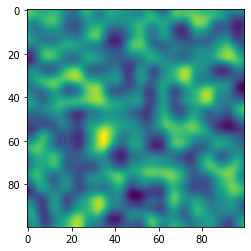

In [227]:
x, y = np.linspace(0, 10, 100), np.linspace(0, 10, 100)
img = np.zeros((len(x), len(y)))

for i, vi in enumerate(x):
    for j, vj in enumerate(y):
        img[i, j] = noise(vi, vj, 8.7, 9.1, 99.22)
        
plt.imshow(img)
plt.show()

In [231]:
%%timeit

for i, vi in enumerate(x):
    for j, vj in enumerate(x):
        for k, vk in enumerate(x):
            noise(vi, vj, vk)

3min 24s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [232]:
%%timeit

for i, vi in enumerate(x):
    for j, vj in enumerate(x):
        for k, vk in enumerate(x):
            noise(vi, vj, vk, grad=original_grad)

25.6 s ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
